In [61]:
import pandas as pd
def get_causal_dfs(dag, n_variables, maxlags):
        """
        Returns the causal dataframes.
        """
        
        pairs = [(source, effect) for source in range(n_variables, n_variables * maxlags + n_variables) for effect in range(n_variables)]
        multi_index = pd.MultiIndex.from_tuples(pairs, names=['source', 'target'])
        causal_dataframe = pd.DataFrame(index=multi_index, columns=['is_causal'])

        causal_dataframe['is_causal'] = 0

        # print(causal_dataframe)
        
        for parent_node, child_node in dag.edges:
            
            if '-' not in child_node:
                child_variable = int(child_node)
                child_lag = 0
            else:
                child_variable = int(child_node.split("_")[0])
                child_lag = int(child_node.split("-")[1])
            
            if child_variable < n_variables:
                corresponding_value_child = child_variable 
                parent_variable = int(parent_node.split("_")[0])
                parent_lag = int(parent_node.split("-")[1])
                corresponding_value_parent = parent_lag * n_variables + parent_variable

                causal_dataframe.loc[(corresponding_value_parent, corresponding_value_child), 'is_causal'] = 1
                

        return causal_dataframe

In [41]:
def custom_layout(G, n_nodes, t_lag):
    """
    Create a custom layout for the graph where nodes with the same identifier
    are aligned in the same column, regardless of their connections.
    """
    pos = {}
    width = 1.0 / (n_nodes - 1)
    height = 1.0 / (t_lag - 1)

    for node in G.nodes():
        if '_t-' in node:
            i, t = map(int, node.split('_t-'))
        else:
            i, t = int(node), 0
        pos[node] = (i * width, t * height)

    # Scale and center the positions
    pos = {node: (x * 10, y * 3) for node, (x, y) in pos.items()}
    return pos


def show_DAG(G, n_nodes, t_lag):
    import networkx as nx
    import matplotlib.pyplot as plt
    # Using the custom layout for plotting
    plt.figure(figsize=(10, 6))
    pos_custom = custom_layout(G, n_nodes, t_lag)
    nx.draw(G, pos_custom, with_labels=True, node_size=1000, node_color="lightpink", font_size=10, arrowsize=10)
    plt.title("Time Series DAG with Custom Layout")
    plt.show()
    
def dag_to_formula(dag):
    import networkx as nx
    formula = ""
    for node in nx.topological_sort(dag):
        if f"_t-" not in str(node):
            formula += f"{node} = "
            bias = dag.nodes[node]['bias']
            parents = list(dag.predecessors(node))
            for parent in parents:
                edge = dag.edges[parent, node]
                weight = edge['weight']
                formula += f"{weight}*{parent} + "
            formula += f"{bias}\n"
    print(formula)

In [1]:
import random
import math
import networkx as nx

In [2]:
# Helper function to compute mean over given indices
def mean_over_indices(Y_t, indices):
    return sum(Y_t[i] for i in indices) / len(indices)

# Indicator function
def I(condition):
    return 1 if condition else 0

# Sign function
def sign(x):
    return -1 if x < 0 else (1 if x > 0 else 0)


In [3]:
# Time series update function for the first formula
def time_series_update_1(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    Y_bar_t_minus_1 = mean_over_indices(Y[t-1], N_j)

    term1 = -0.4 * (3 - Y_bar_t**2) / (1 + Y_bar_t**2)
    term2 = 0.6 * (3 - (Y_bar_t_minus_1 - 0.5)**3) / (1 + (Y_bar_t_minus_1 - 0.5)**4)

    return term1 + term2 + W[t][j]

In [66]:

def build_DAG_time_series_1(T, N_j, N):
    # Create a Directed Acyclic Graph (DAG) using networkx
    G = nx.DiGraph()

    # Add nodes and edges to the DAG based on the dependencies
    for t in range(T):
        for j in range(N):
            if t > 0:
                # Add the current and previous Y nodes if not already present
                G.add_node(f"Y[{t}][{j}]")
                G.add_node(f"Y[{t+1}][{j}]")
                
                # Add edges from the current and previous Y to the next Y
                for nj in N_j:
                    G.add_edge(f"Y[{t}][{nj}]", f"Y[{t+1}][{j}]")
                    G.add_edge(f"Y[{t-1}][{nj}]", f"Y[{t+1}][{j}]")
                
                
    return G

In [67]:


# Time series update function for the second formula
def time_series_update_2(Y, t, j, N_j, W):
    Y_bar_t_minus_5 = mean_over_indices(Y[t-5], N_j)
    Y_bar_t_minus_9 = mean_over_indices(Y[t-9], N_j)

    term1 = (0.4 - 2 * math.exp(-50 * Y_bar_t_minus_5**2)) * Y_bar_t_minus_5
    term2 = (0.5 - 0.5 * math.exp(-50 * Y_bar_t_minus_9**2)) * Y_bar_t_minus_9

    return term1 + term2 + W[t][j]


In [83]:

def build_DAG_time_series_2(T, N_j, N):
    # Create a new Directed Acyclic Graph (DAG) using networkx for the second formula
    G2 = nx.DiGraph()

    # Add nodes and edges to the DAG based on the dependencies for the second formula
    for t in range(1, T):
        for j in range(N):
            # Add the current Y node if not already present
            G2.add_node(f"Y[{t}][{j}]")
            
            # For t >= 5, add edges from Y[t-5] to Y[t]
            if t >= 5:
                for nj in N_j:
                    G2.add_node(f"Y[{t-5}][{nj}]")
                    G2.add_edge(f"Y[{t-5}][{nj}]", f"Y[{t}][{j}]")
            
            # For t >= 9, add edges from Y[t-9] to Y[t]
            if t >= 9:
                for nj in N_j:
                    G2.add_node(f"Y[{t-9}][{nj}]")
                    G2.add_edge(f"Y[{t-9}][{nj}]", f"Y[{t}][{j}]")
            
            

    return G2

In [84]:
# Time series update function for the third formula
def time_series_update_3(Y, t, j, N_j, W):
    Y_bar_t_minus_1 = mean_over_indices(Y[t-1], N_j)
    Y_bar_t_minus_2 = mean_over_indices(Y[t-2], N_j)

    term1 = 1.5 * math.sin(math.pi / 2 * Y_bar_t_minus_1)
    term2 = -math.sin(math.pi / 2 * Y_bar_t_minus_2)

    return term1 + term2 + W[t][j]


In [85]:
def build_DAG_time_series_3(T, N_j, N):
    # Create a Directed Acyclic Graph (DAG) using networkx for the third formula
    G3 = nx.DiGraph()

    # Add nodes and edges to the DAG based on the dependencies for the third formula
    for t in range(2, T):  # Start from t=2 since the formula depends on t-1 and t-2
        for j in range(N):
            # Add the current and previous two Y nodes if not already present
            G3.add_node(f"Y[{t}][{j}]")
            G3.add_node(f"Y[{t+1}][{j}]")

            # Add edges from the previous and the one before last Y to the next Y
            for nj in N_j:
                G3.add_edge(f"Y[{t-1}][{nj}]", f"Y[{t+1}][{j}]")
                G3.add_edge(f"Y[{t-2}][{nj}]", f"Y[{t+1}][{j}]")
            

    return G3


In [86]:
# Time series update function for the fourth formula you provided
def time_series_update_4(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    Y_bar_t_minus_1 = mean_over_indices(Y[t-1], N_j)

    term1 = 2 * math.exp(-0.1 * Y_bar_t**2) * Y_bar_t
    term2 = -math.exp(-0.1 * Y_bar_t_minus_1**2) * Y_bar_t_minus_1

    return term1 + term2 + W[t][j]



In [87]:
def build_DAG_time_series_4(T, N_j, N):
    # Create a Directed Acyclic Graph (DAG) using networkx for the fourth formula
    G4 = nx.DiGraph()

    # Add nodes and edges to the DAG based on the dependencies for the fourth formula
    for t in range(1, T):  # Start from t=1 since the formula depends on t and t-1
        for j in range(N):
            # Add the current and previous Y nodes if not already present
            G4.add_node(f"Y[{t}][{j}]")
            G4.add_node(f"Y[{t+1}][{j}]")

            # Add edges from the current and previous Y to the next Y
            for nj in N_j:
                G4.add_edge(f"Y[{t}][{nj}]", f"Y[{t+1}][{j}]")
                G4.add_edge(f"Y[{t-1}][{nj}]", f"Y[{t+1}][{j}]")
            

    return G4

In [88]:
# Time series update function for the fifth formula you provided
def time_series_update_5(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)

    term1 = -2 * Y_bar_t * I(Y_bar_t < 0)
    term2 = 0.4 * Y_bar_t * I(Y_bar_t < 0)

    return term1 + term2 + W[t][j]


In [89]:
def build_DAG_time_series_5(T, N_j, N):
    # Create a Directed Acyclic Graph (DAG) using networkx for the fifth formula
    G5 = nx.DiGraph()

    # Add nodes and edges to the DAG based on the dependencies for the fifth formula
    for t in range(1, T):  # Start from t=1 since the formula depends on t
        for j in range(N):
            # Add the current Y nodes if not already present
            G5.add_node(f"Y[{t}][{j}]")
            G5.add_node(f"Y[{t+1}][{j}]")

            # Add edges from the current Y to the next Y
            for nj in N_j:
                G5.add_edge(f"Y[{t}][{nj}]", f"Y[{t+1}][{j}]")
            

    return G5


In [90]:
# Time series update function for the sixth formula you provided
def time_series_update_6(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    Y_bar_t_minus_2 = mean_over_indices(Y[t-2], N_j)

    term1 = 0.8 * math.log(1 + 3 * Y_bar_t**2)
    term2 = -0.6 * math.log(1 + 3 * Y_bar_t_minus_2**2)

    return term1 + term2 + W[t][j]


In [9]:
def time_series_update_7(Y, t, j, N_j, W):
    Y_bar_t_minus_5 = mean_over_indices(Y[t-5], N_j)
    Y_bar_t_minus_9 = mean_over_indices(Y[t-9], N_j)

    term1_part1 = 0.4 - 2 * math.cos(40 * Y_bar_t_minus_5) * math.exp(-30 * Y_bar_t_minus_5**2)
    term1 = term1_part1 * Y_bar_t_minus_5
    term2 = (0.5 - 0.5 * math.exp(-50 * Y_bar_t_minus_9**2)) * Y_bar_t_minus_9

    return term1 + term2 + W[t][j]


In [10]:
def time_series_update_8(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    Y_bar_t_minus_2 = mean_over_indices(Y[t-2], N_j)

    term1 = (0.5 - 1.1 * math.exp(-50 * Y_bar_t**2)) * Y_bar_t
    term2 = (0.3 - 0.5 * math.exp(-50 * Y_bar_t_minus_2**2)) * Y_bar_t_minus_2

    return term1 + term2 + W[t][j]


In [11]:

# Time series update function for the ninth formula you provided
def time_series_update_9(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    Y_bar_t_minus_1 = mean_over_indices(Y[t-1], N_j)

    term1 = 0.3 * Y_bar_t
    term2 = 0.6 * Y_bar_t_minus_1
    term3_numerator = 0.1 - 0.9 * Y_bar_t + 0.8 * Y_bar_t_minus_1
    term3_denominator = 1 + math.exp(-10 * Y_bar_t)
    term3 = term3_numerator / term3_denominator

    return term1 + term2 + term3 + W[t][j]


In [12]:
# Time series update function for the tenth formula you provided
def time_series_update_10(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    return sign(Y_bar_t) + W[t][j]


In [13]:
# Time series update function for the eleventh formula you provided
def time_series_update_11(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    term1 = 0.8 * Y_bar_t
    term2_denominator = 1 + math.exp(-10 * Y_bar_t)
    term2 = -0.8 * Y_bar_t / term2_denominator

    return term1 + term2 + W[t][j]


In [14]:
# Time series update function for the twelfth formula you provided
def time_series_update_12(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    Y_bar_t_minus_1 = mean_over_indices(Y[t-1], N_j)

    term1 = 0.3 * Y_bar_t
    term2 = 0.6 * Y_bar_t_minus_1
    term3_numerator = 0.1 - 0.9 * Y_bar_t + 0.8 * Y_bar_t_minus_1
    term3_denominator = 1 + math.exp(-10 * Y_bar_t)
    term3 = term3_numerator / term3_denominator

    return term1 + term2 + term3 + W[t][j]


In [15]:
def time_series_update_13(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    Y_bar_t_minus_1 = mean_over_indices(Y[t-1], N_j)

    term1 = 0.38 * Y_bar_t * (1 - Y_bar_t_minus_1)

    return term1 + W[t][j]


In [16]:
def time_series_update_14(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)

    if Y_bar_t < 1:
        return -0.5 * Y_bar_t + W[t][j]
    else:
        return 0.4 * Y_bar_t + W[t][j]


In [17]:
def time_series_update_15(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)

    if abs(Y_bar_t) < 1:
        return 0.9 * Y_bar_t + W[t][j]
    else:
        return -0.3 * Y_bar_t + W[t][j]


In [18]:
def update_x(x_t):
    return 1 - x_t

# Time series update function for the sixteenth formula you provided
def time_series_update_16(Y, t, j, N_j, W, x_t):
    Y_bar_t = mean_over_indices(Y[t], N_j)

    if x_t == 1:
        return -0.5 * Y_bar_t + W[t][j]
    else:
        return 0.4 * Y_bar_t + W[t][j]


In [19]:
def time_series_update_17(Y, t, j, N_j, W):
    Y_bar_t = mean_over_indices(Y[t], N_j)
    Y_bar_t_minus_1 = mean_over_indices(Y[t-1], N_j)
    Y_bar_t_minus_2 = mean_over_indices(Y[t-2], N_j)
    Y_bar_t_minus_3 = mean_over_indices(Y[t-3], N_j)

    squared_sum = (
        Y_bar_t**2 + 
        0.3 * Y_bar_t_minus_1**2 + 
        0.2 * Y_bar_t_minus_2**2 + 
        0.1 * Y_bar_t_minus_3**2
    )

    coefficient = math.sqrt(0.000019 + 0.846 * squared_sum)

    return coefficient * W[t][j]


In [20]:
# Simple simulation

# Initialize parameters
T = 200  # Time steps
N = 5   # number of j indices

In [91]:

Y1 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 1
Y2 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 2
Y3 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 3
Y4 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 4
Y5 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 5
Y6 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 6
Y7 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 7
Y8 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 8
Y9 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 9
Y10 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 10
Y11 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 11
Y12 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 12
Y13 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 13
Y14 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 14
Y15 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 15

x = [1] + [0 for _ in range(T)]
Y16 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 16
Y17 = [[random.uniform(-1, 1) for _ in range(N)] for _ in range(T+1)]  # For time series 17



W = [[random.uniform(-0.1, 0.1) for _ in range(N)] for _ in range(T+1)]  # Some noise #TODO: make sure the covariance matrix is positive definite (diagonal better)
N_j = [0, 2, 3]  # Sample set of indices for N_j


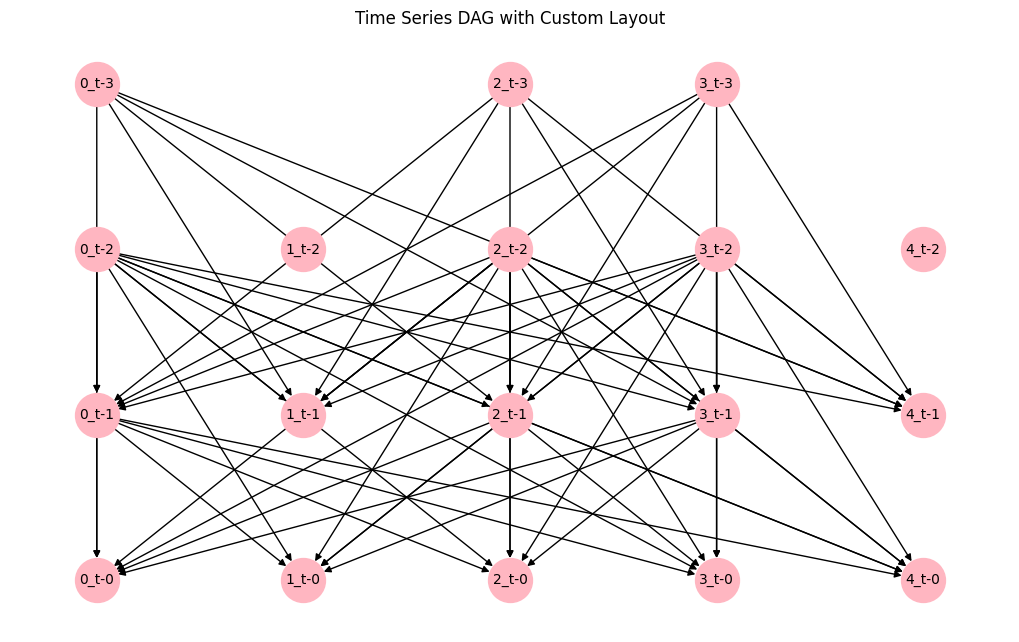

In [92]:
lag = 3
dag = build_DAG_time_series_1(T=lag,N_j=N_j, N=N)
rename_dict = {f"Y[{t}][{j}]": f"{j}_t-{lag-t}" for t in range(lag+1) for j in range(N)}
dag = nx.relabel_nodes(dag, rename_dict)
show_DAG(dag, N, lag+1)

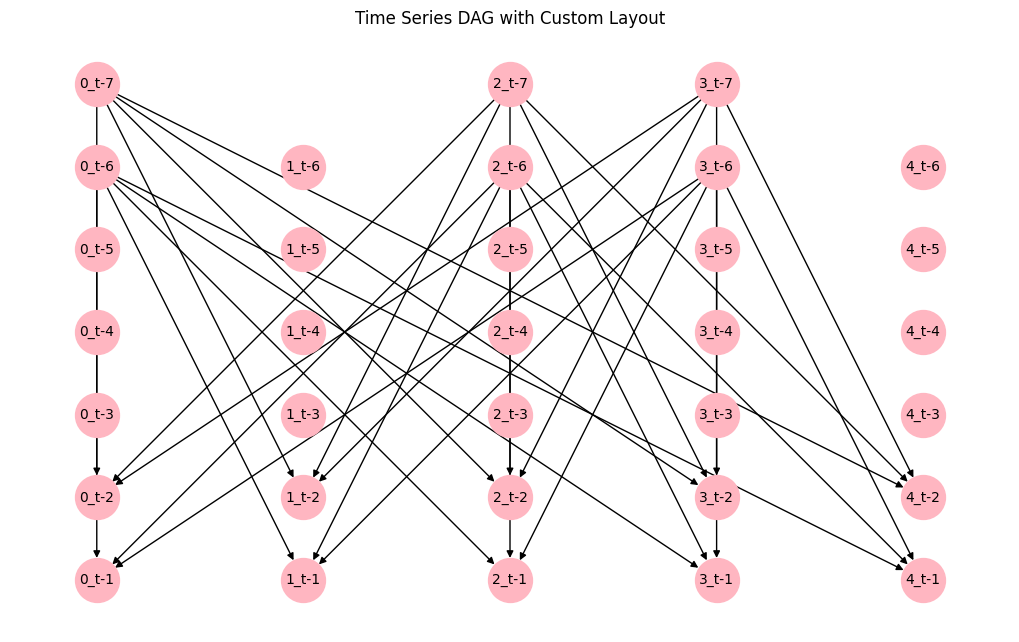

In [96]:
lag = 7
dag = build_DAG_time_series_2(T=lag,N_j=N_j, N=N)
rename_dict = {f"Y[{t}][{j}]": f"{j}_t-{lag-t}" for t in range(lag+1) for j in range(N)}
dag = nx.relabel_nodes(dag, rename_dict)
show_DAG(dag, N, lag+1)

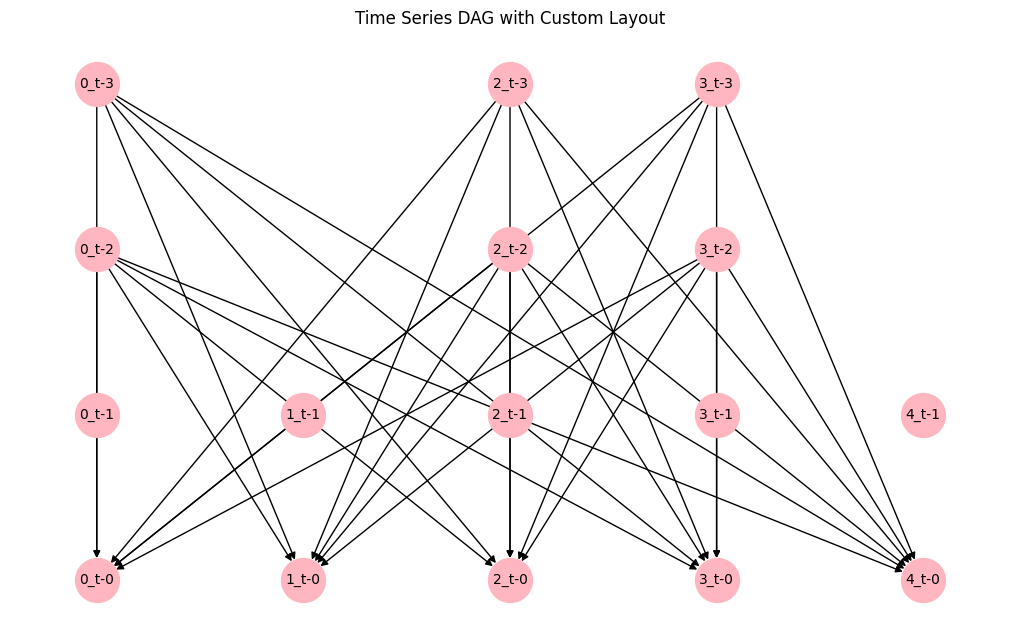

In [97]:
lag = 3
dag = build_DAG_time_series_3(T=lag,N_j=N_j, N=N)
rename_dict = {f"Y[{t}][{j}]": f"{j}_t-{lag-t}" for t in range(lag+1) for j in range(N)}
dag = nx.relabel_nodes(dag, rename_dict)
show_DAG(dag, N, lag+1)

In [98]:
get_causal_dfs(dag, N, lag).T

source    5              6               ... 18             19            
target     0  1  2  3  4  0  1  2  3  4  ...  0  1  2  3  4  0  1  2  3  4
is_causal  0  0  0  0  0  0  0  0  0  0  ...  1  1  1  1  1  0  0  0  0  0

[1 rows x 75 columns]

In [22]:

# Time series iteration for the first formula
for t in range(T):
    for j in range(N):
        if t > 0:
            Y1[t+1][j] = time_series_update_1(Y1, t, j, N_j, W)

# Time series iteration for the second formula
for t in range(9, T):  # Start from t=9 as the formula requires t-9
    for j in range(N):
        Y2[t+1][j] = time_series_update_2(Y2, t, j, N_j, W)

# Time series iteration for the third formula
for t in range(2, T):  # Start from t=2 as the formula requires t-2
    for j in range(N):
        Y3[t+1][j] = time_series_update_3(Y3, t, j, N_j, W)

# Time series iteration for the fourth formula
for t in range(1, T):  # Start from t=1 as the formula requires t-1
    for j in range(N):
        Y4[t+1][j] = time_series_update_4(Y4, t, j, N_j, W)

for t in range(T):
    for j in range(N):
        Y5[t+1][j] = time_series_update_5(Y5, t, j, N_j, W)

for t in range(2, T):  # Start from t=2 as the formula requires t-2
    for j in range(N):
        Y6[t+1][j] = time_series_update_6(Y6, t, j, N_j, W)

for t in range(9, T):  # Start from t=9 as the formula requires t-9
    for j in range(N):
        Y7[t+1][j] = time_series_update_7(Y7, t, j, N_j, W)

for t in range(2, T):  # Start from t=2 as the formula requires t-2
    for j in range(N):
        Y8[t+1][j] = time_series_update_8(Y8, t, j, N_j, W)

for t in range(1, T):  # Start from t=1 as the formula requires t-1
    for j in range(N):
        Y9[t+1][j] = time_series_update_9(Y9, t, j, N_j, W)

for t in range(T):
    for j in range(N):
        Y10[t+1][j] = time_series_update_10(Y10, t, j, N_j, W)

for t in range(T):
    for j in range(N):
        Y11[t+1][j] = time_series_update_11(Y11, t, j, N_j, W)

for t in range(1, T):  # Start from t=1 as the formula requires t-1
    for j in range(N):
        Y12[t+1][j] = time_series_update_12(Y12, t, j, N_j, W)

for t in range(1, T):  # Start from t=1 as the formula requires t-1
    for j in range(N):
        Y13[t+1][j] = time_series_update_13(Y13, t, j, N_j, W)

for t in range(T):
    for j in range(N):
        Y14[t+1][j] = time_series_update_14(Y14, t, j, N_j, W)

for t in range(T):
    for j in range(N):
        Y15[t+1][j] = time_series_update_15(Y15, t, j, N_j, W)

for t in range(T):
    for j in range(N):
        Y16[t+1][j] = time_series_update_16(Y16, t, j, N_j, W, x[t])
    x[t+1] = update_x(x[t])

for t in range(3, T):  # Start from t=3 as the formula requires t-3
    for j in range(N):
        Y17[t+1][j] = time_series_update_17(Y17, t, j, N_j, W)




In [23]:

import pandas as pd
for series in [Y1, Y2, Y3, Y4, Y5, Y6, Y7, Y8, Y9, Y10, Y11, Y12, Y13, Y14, Y15]:
    print("Time Series:")
    print(pd.DataFrame(series))


Time Series:
            0         1         2         3         4
0   -0.829666 -0.367804 -0.213773 -0.676894  0.088800
1    0.276809  0.837437  0.459088  0.125813  0.560632
2    0.080687  0.038646  0.095609  0.049091 -0.038078
3    0.642569  0.592658  0.661731  0.696763  0.544996
4    1.033971  1.062560  1.135325  1.024772  1.109240
..        ...       ...       ...       ...       ...
196  0.631594  0.643213  0.656237  0.607578  0.636278
197  0.088202  0.164245  0.070851  0.165240  0.096407
198  0.588318  0.696368  0.605019  0.662888  0.549511
199  1.134469  1.081052  0.944110  1.025036  1.075492
200  1.504147  1.423861  1.365420  1.497940  1.381307

[201 rows x 5 columns]
Time Series:
            0         1         2         3         4
0   -0.022191  0.857372  0.420501  0.669459  0.436790
1    0.162919 -0.732696  0.331800  0.961134  0.910135
2    0.796398 -0.504056  0.128724  0.457778 -0.978301
3    0.422833  0.154235 -0.065627  0.803581  0.646240
4   -0.000419  0.336954 -0.84402